# Latent Dirichlet Allocation

This notebook performs LDA on the SC law corpus.

Topic modeling is a method for finding common themes from unstructured text and is useful in giving a comprehensive overview. Unlike traditional clustering, it embraces mixed membership, recognizing that data points can belong to multiple categories.

Consider a scenario where we manually create topics for a collection of cooking recipes:
- (Italian Cuisine) 50% "pasta," 25% "tomato," 10% "olive oil," 5% "basil"...
- (Baking) 65% "flour," 12% "sugar," 10% "yeast," 5% "vanilla"...
- (Healthy Eating) 42% "vegetables," 15% "quinoa," 7% "salad," 7% "nuts"...

These words are associated with their probabilities of appearing in the topic to the left. So, there is 50% chance that the word "pasta" came from the Italian Cuisine topic. Note that the vocabulary probability will sum up to 1 for every topic, but often times, words that have lower weights will be truncated from the output.

The same concept extends to documents, allowing automated extraction of topics and document probabilities without manual labeling, exemplifying unsupervised machine learning.

Latent Dirichlet Allocation (LDA) is a popular topic modeling algorithm and requires documents to be represented as a bag of words. This representation ignores word ordering in the document but retains information on how many times each word appears.

<br>Source(s) used:
* https://doi.org/10.17615/tksc-t217
* https://ethen8181.github.io/machine-learning/clustering/topic_model/LDA.html
* https://medium.com/towards-data-science/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
* https://towardsdatascience.com/nlp-preprocessing-and-latent-dirichlet-allocation-lda-topic-modeling-with-gensim-713d516c6c7d

In [1]:
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import pickle

from gensim import corpora, models
from gensim.models import CoherenceModel
from gensim.models.phrases import Phrases, Phraser
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
from pprint import pprint
from typing import List, Set, Dict

# Since importing hyperopt and pyLDAvis might generate deprecation warnings
# Filter those warnings here.
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    from hyperopt import fmin, tpe, hp
    import pyLDAvis.gensim

# change default figure and font size
plt.rcParams['figure.figsize'] = 8, 6 
plt.rcParams['font.size'] = 12

In [2]:
%load_ext watermark
%config InlineBackend.figure_format = 'retina'
%watermark --iso8601 -u -v -m -iv 

Last updated: 2024-03-07T14:13:36.676542-05:00

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.16.1

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.3.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

hyperopt  : 0.2.7
pandas    : 2.0.3
pyLDAvis  : 3.4.1
matplotlib: 3.8.2
re        : 2.2.1
gensim    : 4.3.2



<b>Note: </b>Hyperopt does not (at the time of writing this notebook) work with Python version 3.12. For this reason, it is recommended to use an eariler version of Python.

<br>

## Data Acquisition and Pre-Processing
Get the data file and read all the sentences.
<br>
To avoid pre-processing the sentences repeatedly when rerunning the notebook, save them on disk.

In [3]:
def load_sentences() -> pd.Series:
    """
    Load the split sentences and return a Pandas Series for those sentences.

    @return: A Pandas Series object that contains the just the sentences 
        (along with a default index).
    """
    
    # Path to the final split csv
    f_path: str = "/Users/nitingupta/Desktop/OTB/final_splits_Nov3.csv"
    
    # Use only the id (containing the years) and the sentences column
    df: pd.DataFrame = pd.read_csv(f_path, index_col = 0, usecols=['id', 'sentence'])
    
    # Get the years
    df['year']: pd.Series = df.index.str.split("_").str[0]
    df.set_index('year', inplace=True)
    df.reset_index(inplace=True)
    
    # Convert to Series to get the 'sentence' column as a string type
    sentences: pd.Series = pd.Series(df['sentence'], dtype="string")

    return sentences

In [4]:
def clean(sentence : str, stop_words: Set[str], lemmatizer: WordNetLemmatizer) -> List[str]:
    """
    Perform a basic cleaning on the given sentences.
    Cleaning includes:
        - Hyphen removals from words that appeared at the end of a sentence and were split to the next line.
        - Lowercasing
        - Tokenization
        - Removal of words that do not exclusively contain letters
        - Removing stopwords
        - Lemmatization

    @param sentence: A string of sentence
    @param stop_words: A set of string stop words
    @lemmatizer: A WordNetLemmatizer
    @return: A List of strings contained the cleaned words for the sentence
    """

    # Hyphen removal
    sentence = re.sub(r'(—|_|-)( )*', '', str(sentence))
    
    # Lowercase and tokenize
    tokens = word_tokenize(sentence.lower())
    
    # Keep only letters
    words_alpha = [word for word in tokens if word.isalpha()]
    
    # Stopword Removal
    filtered_tokens = [word for word in words_alpha if word not in stop_words]
    
    # Lemmatization
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_tokens]
    
    return lemmatized_words

In [5]:
def pre_processing(sentences: pd.Series) -> List[List[str]]:
    """
    Perform pre-processing on the given `sentences`.
    Utilize the `clean` function defined above.
    Also, convert potential words to bigrams.
    Return a List of List of Strings.

    @param sentences: A Pandas Series representing the sentences need for pre processing.
    @return: A List of List of strings that contains the processed sentence tokens.
    """

    # Load in the stopwords from the NLTK library
    stop_words: List[str] = stopwords.words('english')
    
    # Add custom stop words fromt the `custom_stopwords.txt` file
    # This is done to remove corpus sepcific words.
    # Most of these custom words were brought from Dalwadi's paper (see sources).
    with open('stopwords/custom_stopwords.txt', 'r') as f:
        stop_words += f.read().splitlines()
    
    # Convert to a set for faster computations
    stop_words: Set[str] = set(stop_words)
    
    print(f"Number of stop words: {len(stop_words)}")

    # Initialize the WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()

    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        # Apply the "clean" function to each sentence
        cleaned_sents: pd.Series = sentences.apply(lambda x: clean(x, stop_words, lemmatizer))

    # Convert potential words to bigrams.
    bigram = Phrases(cleaned_sents, min_count=5, threshold=100)
    bigram_mod = Phraser(bigram)

    cleaned_sents: List[List[str]] = [bigram_mod[text] for text in cleaned_sents.tolist()]

    return cleaned_sents

In [6]:
# directory for storing all data, such lda models and cleaned sentences
model_dir = 'checkpoint'
if not os.path.isdir(model_dir):
    print(f"Making directory for storing data: {model_dir}")
    os.mkdir(model_dir)

# Create the path to store the cleaned sentences
cleaned_sents_path = os.path.join(model_dir, 'cleaned_sentences.pkl')

if os.path.exists(cleaned_sents_path):
    print(f"File at {cleaned_sents_path}\" exists! Reading from file.")
    
    with open(cleaned_sents_path, 'rb') as f:
        cleaned_sents: List[List[str]] = pickle.load(f)

else:
    print(f"File at \"{cleaned_sents_path}\" does not exists! Performing calculations.")
    
    cleaned_sents: List[List[str]] = pre_processing(load_sentences())

    print(f"Saving cleaned senteces at \"{cleaned_sents_path}\"")
    # Save
    with open(cleaned_sents_path, 'wb') as f:
        pickle.dump(cleaned_sents, f)

File at checkpoint/cleaned_sentences.pkl" exists! Reading from file.


Cleaned sentences is a List of List of strings.

In [7]:
print(f"The number of cleaned sentences: {len(cleaned_sents):,}")
print(f"Sample output: {cleaned_sents[:1]}")

The number of cleaned sentences: 403,481
Sample output: [['accepting', 'benefit', 'donating', 'public', 'land', 'several', 'state', 'territory', 'provide', 'college', 'benefit', 'agriculture', 'mechanic', 'art', 'second', 'july', 'lord_eight', 'sixtytwo']]


<br>

### Visualizing Words
Before making the LDA model, it will be helpful to visualize the data we are working with.

In [8]:
# A list of all cleaned words from the corpus
allwords: List[str] = []
allwords = [x for xs in cleaned_sents for x in xs]
print(f"Total words in the corpus (after cleaning): {len(allwords):,}")

Total words in the corpus (after cleaning): 8,115,803


In [9]:
# Count word frequencies across the entire corpus
word_counts: Counter = Counter(allwords)  # Dictionary containing word -> frequency
print(f"Number of unique words in the corpus (after cleaning): {len(word_counts):,}")

Number of unique words in the corpus (after cleaning): 112,639


In [10]:
# Convert to a dataframe to get the plots and descriptive statistics
df_word_counts: pd.DataFrame = pd.DataFrame.from_dict(word_counts, orient='index', columns=['frequency'])
df_word_counts.describe()

,frequency
count,112639.000000
mean,72.051448
std,964.813072
min,1.000000
25%,1.000000
50%,1.000000
75%,4.000000
max,75359.000000


Many words have similar frequencies, as shown with the statistics above, and most of them are in the lower frequency range.
<br>For example, 50% of all unique words occur only once.
<br>So, plot the unique frequencies across the words.

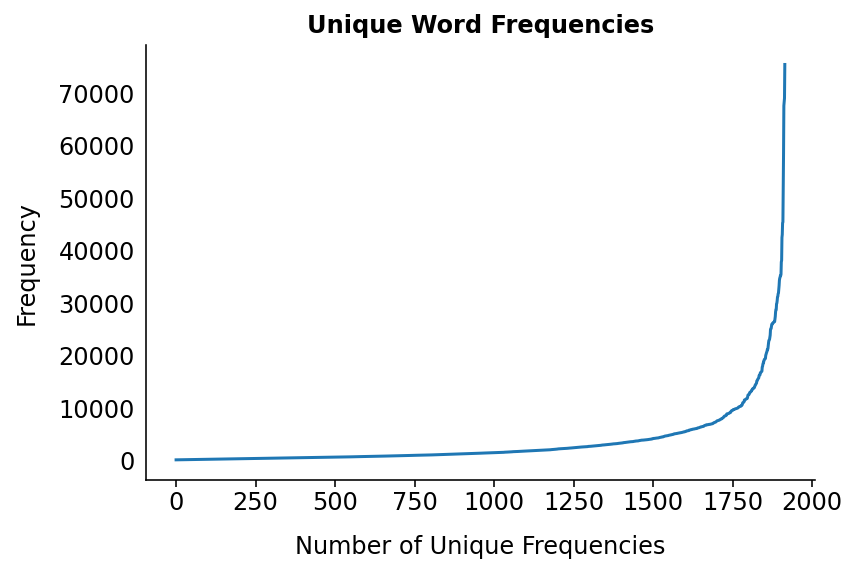

In [11]:
fig, ax = plt.subplots()
plt.plot(sorted(list(set(word_counts.values()))))
# plt.plot(sorted(word_counts.values()))

# Reformat x-axis label and tick labels
ax.set_xlabel('Number of Unique Frequencies', fontsize=12, labelpad=10)  # No need for an axis label
ax.xaxis.set_label_position("bottom")
ax.xaxis.set_tick_params(pad=2, labelbottom=True, bottom=True, labelsize=12, labelrotation=0)

# Reformat y-axis
ax.set_ylabel('Frequency', fontsize=12, labelpad=10)
ax.yaxis.set_label_position("left")
ax.yaxis.set_tick_params(pad=2, labeltop=False, labelbottom=True, bottom=False, labelsize=12)

# Remove the spines
ax.spines[['top', 'right']].set_visible(False)

# Add in title
ax.set_title("Unique Word Frequencies", weight='bold')

# Set a white background
fig.patch.set_facecolor('white')

The plot suggests that most of the words occur a low number of times, and only a few ones have a high number of occurences.

<br>

## LDA
Use the `Gensim` library to make the model.<br>

### Model Training

In [12]:
# Create a dictionary: a mapping between words and their integer ids
dictionary = corpora.Dictionary(cleaned_sents)

In [13]:
print(f"Length of the dictionary before filtering: {len(dictionary):,}")

Length of the dictionary before filtering: 112,639


Filter out extreme words that won't be helpful in the topic modeling.
<br>While removing stop words, previously, took care of the common words, words that are too rare (to constitute a meaningful topic or too common to add any meaning) were not considered.
<br>Eliminate words below a frequency threshold, meaning that words that occur below the value will be removed

In [14]:
# The `no_below` parameter keeps tokens which are contained in at least `no_below` documents.
# The `no_above` parameter represents the percent of tokens to keep which should be contained in no more than `no_above`*100% specified documents.
    # This value is kept at 1.0 since the common words were already removed as part of the stop word removal process.
    # So, remove words appearing in more than 100% of the documents (which is nothing, so no words are removed).
# The `keep_n` parameter keeps the first `keep_n` most frequent tokens (or keep all if None) after applying the previous 2 parameters.
dictionary.filter_extremes(no_below=10, no_above=1, keep_n=None)

print(f"Length of the dictionary after filtering: {len(dictionary):,}")

Length of the dictionary after filtering: 17,034


In [15]:
# Convert document into the bag-of-words format
corpus = [dictionary.doc2bow(text) for text in cleaned_sents]

Since LDA uses randomness within its algorithms, it yields slighty different output for different runs on the same data. 
To make sure that the output are consistent and to save some time, the model will be saved without having to rebuild it every single time.

In [16]:
make_new_model = True

<b>Note: </b> To make a new model, either keep the `make_new_model` variable's value to True or clear the contents in `model_dir`.

In [17]:
# Make a new model if the `make_new_model` value is True
# or no model file exists.
model_path = os.path.join(model_dir, 'topic_model.lda')
if make_new_model or not os.path.isfile(model_path):
    print(f"Since an LDA model doesn't already exist, a new model is being made and saved to \"{model_path}\"...")

    # Use parallelized Latent Dirichlet Allocation to parallelize and speed up model training
    lda_model = models.ldamulticore.LdaMulticore(corpus=corpus,
                                                 id2word=dictionary,
                                                 num_topics=10,
                                                 per_word_topics=True)
    # Save the model
    lda_model.save(model_path)

print('Loading model')
lda_model = models.ldamodel.LdaModel.load(model_path)

Since an LDA model doesn't already exist, a new model is being made and saved to "checkpoint/topic_model.lda"...
Loading model


### Interpreting LDA Topics

* Upon constructing the model, our focus shifts to identifying topics acquired by the model, anticipating recognizable categories. 
* In LDA, a topic is a probability distribution over words, assigning distinct probabilities to each unique word in the dataset. 
* Examining the top 10 words for each topic reveals predominant themes. 
* Document-topic membership is expressed as a weight vector, where each weight signifies the document's representation of a specific topic.
<br><b>Note: </b>LDA's distinctive feature is mixed membership, allowing documents to partially belong to multiple topics. 

In [18]:
# Get the 2 most significant topics.
# Show in word-probability pairs.
for topic in lda_model.show_topics(formatted=False)[:2]:
    pprint(topic)

(0,
 [('election', 0.030305203),
  ('notice', 0.012181325),
  ('city', 0.011945516),
  ('vote', 0.008611365),
  ('office', 0.008590007),
  ('property', 0.008067622),
  ('place', 0.0077641145),
  ('day', 0.007291329),
  ('council', 0.0068734726),
  ('member', 0.0067599406)])
(1,
 [('bond', 0.03340436),
  ('interest', 0.028863179),
  ('note', 0.017628573),
  ('payment', 0.013722648),
  ('issue', 0.012205092),
  ('authorized', 0.011921401),
  ('amount', 0.0112240575),
  ('principal', 0.011160087),
  ('loan', 0.0107483),
  ('property', 0.0106759835)])


### Assessing Top Word Significance

To delve deeper into topics, we can analyze the probability distribution (or weight) assigned to their top words. This involves visualizing the weights of the top 100 words, sorted by size, for each of the four topics.

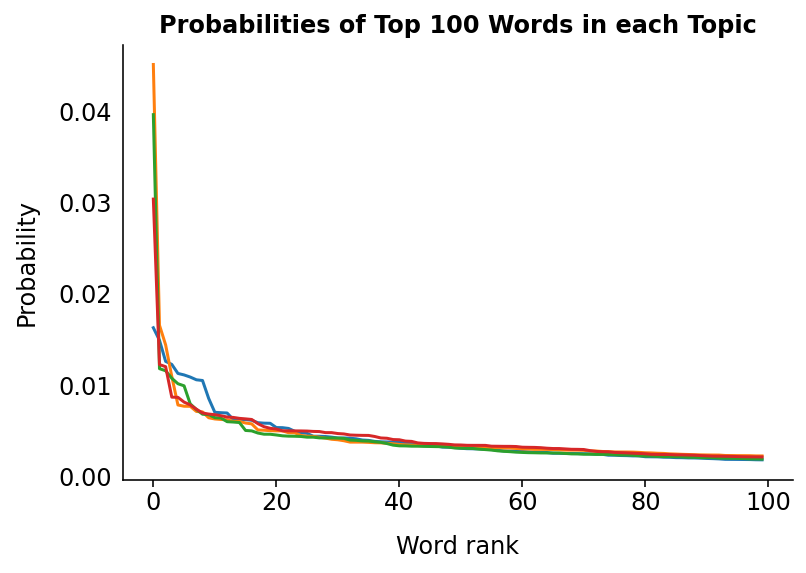

In [19]:
fig, ax = plt.subplots()

# top 100 words by weight in each topic
top_n_words = 100
topics = lda_model.show_topics(num_topics=4,
                               num_words=top_n_words,
                               formatted=False)

for _, infos in topics:
    probs = [prob for _, prob in infos]
    plt.plot(range(top_n_words), probs)

# Reformat x-axis label and tick labels
ax.set_xlabel('Word rank', fontsize=12, labelpad=10)  # No need for an axis label
ax.xaxis.set_label_position("bottom")
ax.xaxis.set_tick_params(pad=2, labelbottom=True, bottom=True, labelsize=12, labelrotation=0)

# Reformat y-axis
ax.set_ylabel('Probability', fontsize=12, labelpad=10)
ax.yaxis.set_label_position("left")
ax.yaxis.set_tick_params(pad=2, labeltop=False, labelbottom=True, bottom=False, labelsize=12)

# Remove the spines
ax.spines[['top', 'right']].set_visible(False)

# Add in title
ax.set_title("Probabilities of Top 100 Words in each Topic", weight='bold')

# Set a white background
fig.patch.set_facecolor('white')
plt.show()

The plot illustrates a sharp decline in weights as we move down the list of most important words for each topic.
<br>This pattern highlights that the first 10 to 20 words in each topic carry significantly greater weight than the subsequent words.

### Evaluation Metrics

Two evaluation metrics to consider for topic modeling: perplexity and coherence.
* Perplexity: Captures how surprised a model is of new data it has not seen before, and is measured as the normalized log-likelihood of a held-out test set. Similar to how well does the model represent or reproduce the statistics of the held-out data.
* Coherence : A set of statements or facts is said to be coherent, if they support each other. Topic Coherence calculates the score of a single topic by measuring the degree of semantic similarity between high scoring words in the topic. These measurements help distinguish between topics that are semantically interpretable topics and topics that are artifacts of statistical inference.

In [20]:
# Compute Perplexity (lower is better)
print(f"Perplexity: {lda_model.log_perplexity(corpus):.3f}")

Perplexity: -7.400


In [21]:
# Compute Coherence Score (higher is better)
coherence_model_lda = CoherenceModel(model=lda_model,
                                     texts=cleaned_sents, 
                                     dictionary=dictionary,
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f"Coherence Score: {coherence_lda:.3f}")

Coherence Score: 0.624


Going forward, we will want to minimize perplexity and maximize coherence.

## Hyperparamter Tuning

There are 3 main types of paramters that effect the LDA model:
1. `num_topics`: Number of Topics
2. `alpha`: Document-Topic Density
3. `beta`: Word-Topic Density

`alpha` is a parameter that controls the prior distribution over topic weights in each document, while `eta` is a parameter for the prior distribution over word weights in each topic. In gensim, both default to a `symmetric` (1 / `num_topics`).
<br>`alpha` and `eta` can be thought of as smoothing parameters when we compute how much each document "likes" a topic (in the case of alpha) or how much each topic "likes" a word (in the case of gamma).
<br><br>To find optimal values for these 3 parameters, use HyperOpt which is a Bayesian optimization library that employs probabilistic models to efficiently search through hyperparameter spaces, balancing exploration and exploitation. To find optimal values for the model, the code specifies the hyperparameter search space, defines an objective function, and lets HyperOpt iteratively evaluate and refine hyperparameters to maximize or minimize the chosen performance metric.

<b>Note:</b> The hyperparamter tuning was done using `LDA_best_hyperopt.py`. This file ran on computing clusters using many cores for speeding up the model training, since `gensim` has a parallelized Latent Dirichlet Allocation version to parallelize and speed up model training. The results are read in below.

In [22]:
with open('checkpoint/best_params.pkl', 'rb') as f:
    best_params = pickle.load(f)
best_params

{'num_topics': 16, 'alpha': 0.001, 'eta': 0.001}

In [23]:
# Load the LDA model
# Use parallelized Latent Dirichlet Allocation to parallelize and speed up model training
lda_model = models.ldamulticore.LdaMulticore(corpus=corpus,
                                             id2word=dictionary,
                                             num_topics=best_params['num_topics'],
                                             alpha=best_params['alpha'],
                                             eta=best_params['eta'],
                                             per_word_topics=True)

<br>

## Visualization

Using `pyLDAvis.gensim.prepare`, the code below generates an interactive visualization for the LDA model above.

* **Interactive Topic Visualization:**
   - The main area displays a scatter plot of topics, where each bubble represents a topic.
   - The size of each bubble indicates the prevalence of the topic in the entire corpus.
   - Topics that are closer on the plot are more similar in terms of the words they contain.

* **Topic-Term Distribution:**
   - On the right side, there is a bar chart showing the top terms for the selected topic.
   - The length of the bars represents the frequency of each term within the selected topic.

* **Relevance:**
   - The relevance of each term in the topic is indicated by the color of the bars in the right panel.
   - Darker colors represent higher relevance, helping to identify key terms within each topic.

**Note:** The visualization allows for interactive exploration. Hovering over a bubble or a term displays additional information. Selecting a term updates the right panel with information about its distribution across topics. The code below saves the visualization as an html file, `LDA_vis.html`, which can be opened in a browser and explored further.

In [24]:
pyLDAvis.enable_notebook()

In [25]:
p = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)

In [26]:
pyLDAvis.save_html(p, 'LDA_vis.html')

In [27]:
# Uncomment the following line to run the visualization in this notebook
# # p